In [111]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [112]:
path="C:/Users/dexte/github/RoboSkin/Code/Models/labeller/"
lin_path="/its/home/drs25/Documents/GitHub/RoboSkin/Code/Models/labeller"
X1=np.load(path+"X_data_push.npy")
y1=np.load(path+"y_data_push.npy")

X2=np.load(path+"X_data_edge.npy")
y2=np.load(path+"y_data_edge.npy")

X=np.concatenate([X1,X2])
SIZE=X.shape[1]
X=X.reshape((X.shape[0],133*2*SIZE))/100
y=np.concatenate([y1,y2])/10

X, data_test, y, labels_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(X.shape,y.shape)
print(data_test.shape,labels_test.shape)

(612, 2660) (612, 5)
(154, 2660) (154, 5)


In [123]:

# Define the size of the input (n) and output (m) layers
n_inputs = 133*2*SIZE
m_outputs = len(y[0])


# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Define the neural network model
class SimpleNeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size,layers=[100,10],drop_out_prob=0.2):
        super(SimpleNeuralNetwork, self).__init__()
        self.fc=[nn.Linear(input_size, layers[0])]
        self.fc.append(nn.ReLU())
        self.fc.append(nn.Dropout(p=drop_out_prob))
        for i in range(1,len(layers)): #create layers 
                self.fc.append(nn.Linear(layers[i-1], layers[i]))
                self.fc.append(nn.ReLU())
                self.fc.append(nn.Dropout(p=drop_out_prob))
        self.fc.append(nn.Linear(layers[-1], output_size))
        self.fc_layers = nn.Sequential(*self.fc)
    def forward(self, x):
        x=self.fc_layers(x)
        return x

# Create the neural network
model = SimpleNeuralNetwork(n_inputs, m_outputs)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)



Epoch [1/1500], Loss: 0.0533
Epoch [1001/1500], Loss: 0.0001


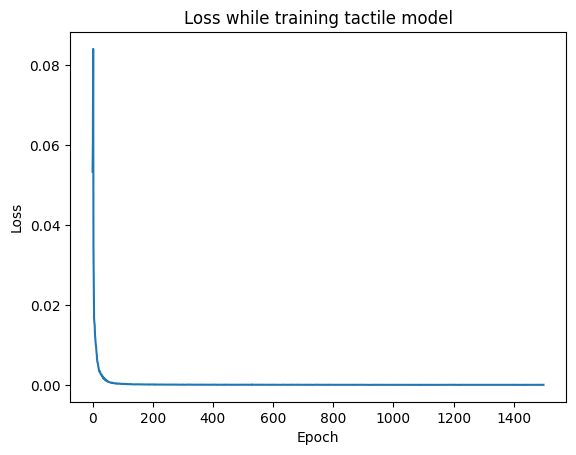

In [124]:
# Training loop
num_epochs = 1500
loss_ar=[]

for epoch in range(num_epochs):
    # Forward pass
    y_pred = model(X_tensor)

    # Compute the loss
    loss = criterion(y_pred, y_tensor)

    # Zero gradients, backward pass, and update the weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_ar.append(loss.item())
    # Print the current loss to monitor training progress
    if epoch%1000==0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


plt.title("Loss while training tactile model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot(loss_ar)
plt.show()

In [125]:
# After training, you can use the trained model for predictions on new data.
# For example, if you have new input data 'X_new', you can do:
with torch.no_grad():
     model.eval()
     predictions = model(torch.tensor(data_test, dtype=torch.float32))


def predict(predictions,should_be=[]):
    predictions*=10 #normalize
    pred_array=np.zeros_like(predictions)
    inds=np.argmax(predictions[:,0:2],axis=1) #convert at threshold
    inds2=np.argmax(predictions[:,2:-1],axis=1) #convert at threshold
    for i in range(len(pred_array)):
        pred_array[i][inds[i]]=1
        pred_array[i][2+inds2[i]]=1
    names=["edge", "surface", "soft", "hard", "slippery"]
    array=[]
    correct=0
    for j,pred in enumerate(pred_array): #loopthrough predictions
        inds=np.where(pred==1) #
        ar=[]
        if len(should_be)>0: #validation task
            sb=should_be[j]*10
            sb=np.where(sb==1)
            if len(sb[0])==len(inds[0]):
                c=0
                for i in range(len(sb[0])):
                    if sb[0][i]==inds[0][i]: c+=1
                if c==len(sb[0]): correct+=1
        for i in inds[0]:
            ar.append(names[i])
        array.append(ar)
    if correct!=0: print("Percentage correct:",(correct/len(should_be))*100,"%")
    return array

p=predict(predictions,should_be=labels_test)
p[0:10]  

Percentage correct: 100.0 %


[['edge', 'hard'],
 ['edge', 'hard'],
 ['surface', 'hard'],
 ['edge', 'hard'],
 ['surface', 'hard'],
 ['edge', 'hard'],
 ['edge', 'hard'],
 ['edge', 'hard'],
 ['surface', 'hard'],
 ['surface', 'hard']]